<a href="https://colab.research.google.com/github/srishtichayal/pothole_segmentation/blob/main/finetuning_sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**FINE TUNING SEGMENT ANYTHING MODEL FOR POTHOLE SEGMENTATION**

##Introduction

In this project, I explore fine-tuning Meta AI's Segment Anything Model (SAM) for pothole segmentation. SAM is a state-of-the-art segmentation model designed to segment objects in images based on prompts, which can be provided in three main forms:
Points (e.g., foreground/background clicks)
Bounding boxes
Free-form masks


By default, SAM does not detect objects automatically. For prompt free inference, It uses an Automatic Mask Generator (AMG), which segments the entire image, but this is not true object detection. Training the full model to adapt AMG specifically for pothole detection is computationally intensive.

One possible workaround is to apply SAM’s AMG and then filter the generated masks using a lightweight CNN trained to classify whether a segment corresponds to a pothole. However, this assumes the AMG is already performing well on potholes—which it typically doesn’t.

To overcome this limitation, I decided to fine-tune SAM using bounding box prompts. Specifically:
*   I use bounding boxes as input prompts for segmentation,
*   Freeze the image encoder and prompt encoder
*   Fine-tune only the mask decoder to improve segmentation performance for potholes.

For inference, the model will still require bounding boxes as prompts. To automate this step, we can train a YOLO-based object detector to detect potholes and generate the necessary bounding boxes. These can then be passed directly to the fine-tuned SAM model to produce precise segmentation masks.

This approach combines the detection capability of YOLO with the powerful segmentation capabilities of SAM, creating a lightweight and modular pipeline for pothole segmentation.

In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-viama4tg
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-viama4tg
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=58f7e17ce2e9fafdedc69e9eb04e55bfbb15003443dd99c725180e8236199979
  Stored in directory: /tmp/pip-ephem-wheel-cache-p65dvxin/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-07-19 17:39:47--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.10, 13.227.219.70, 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import torch.nn.functional as F
from torch.optim import AdamW
from segment_anything.utils.transforms import ResizeLongestSide
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from collections import defaultdict
from statistics import mean
import torch.nn as nn
import pickle

In [4]:
# Set base directory
base_dir = '/content/drive/MyDrive/train'

# Paths to images and labels
image_dir = os.path.join(base_dir, 'images')
label_dir = os.path.join(base_dir, 'labels')

In [5]:
def read_image(img_path):
    """Loads an image from a path."""
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [6]:
def extract_masks_and_bboxes(label_path, img_shape):
    """
    Args:
        label_path (str): path to .txt label file (with polygon coordinates)
        img_shape (tuple): (H, W) of the image (for scaling normalized coords)

    Returns:
        masks (List[np.ndarray]): list of binary masks, each (H, W)
        boxes (List[np.ndarray]): list of bounding boxes [x_min, y_min, x_max, y_max]
    """
    h, w = img_shape
    base_mask = np.zeros((h, w), dtype=np.uint8)

    with open(label_path, 'r') as f:
        for line in f:
            items = [float(x) for x in line.strip().split()]
            coords = items[1:]  # skip class id
            if len(coords) < 6:
                continue

            polygon = []
            for i in range(0, len(coords), 2):
                x = int(round(coords[i] * w))
                y = int(round(coords[i+1] * h))
                polygon.append((x, y))

            cv2.fillPoly(base_mask, [np.array(polygon, dtype=np.int32)], 1)

    # Now separate components in the filled mask
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        base_mask, connectivity=8
    )

    masks = []
    boxes = []

    for i in range(1, num_labels):  # skip background
        component_mask = (labels == i).astype(np.uint8)
        masks.append(component_mask)

        x, y, w_box, h_box, _ = stats[i]
        boxes.append(np.array([x, y, x + w_box, y + h_box]))

    return masks, boxes


In [7]:
sample = "pic-1-_jpg.rf.49882cdb272111f43a6656b1494a4918"
img_path = os.path.join(image_dir, f"{sample}.jpg")
image = read_image(img_path)
label_path = os.path.join(label_dir, f"{sample}.txt")
height, width = image.shape[:2]

In [8]:
masks, boxes = extract_masks_and_bboxes(label_path, (height, width))

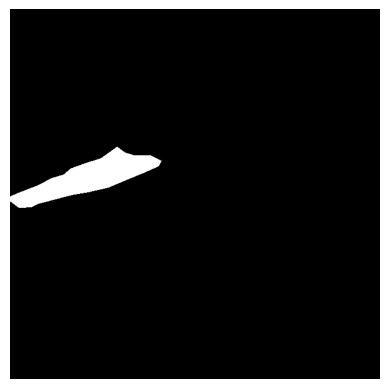

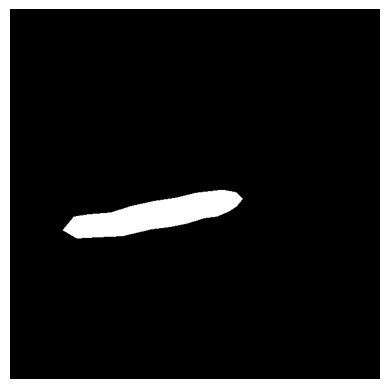

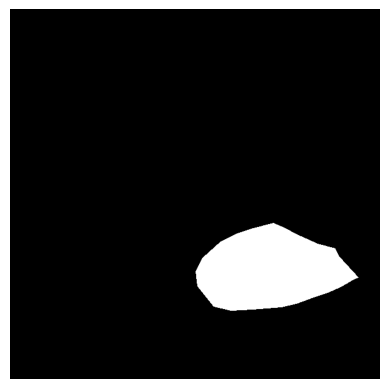

In [9]:
for binary_mask in masks:
  plt.imshow(binary_mask, cmap='gray')
  plt.axis('off')
  plt.show()

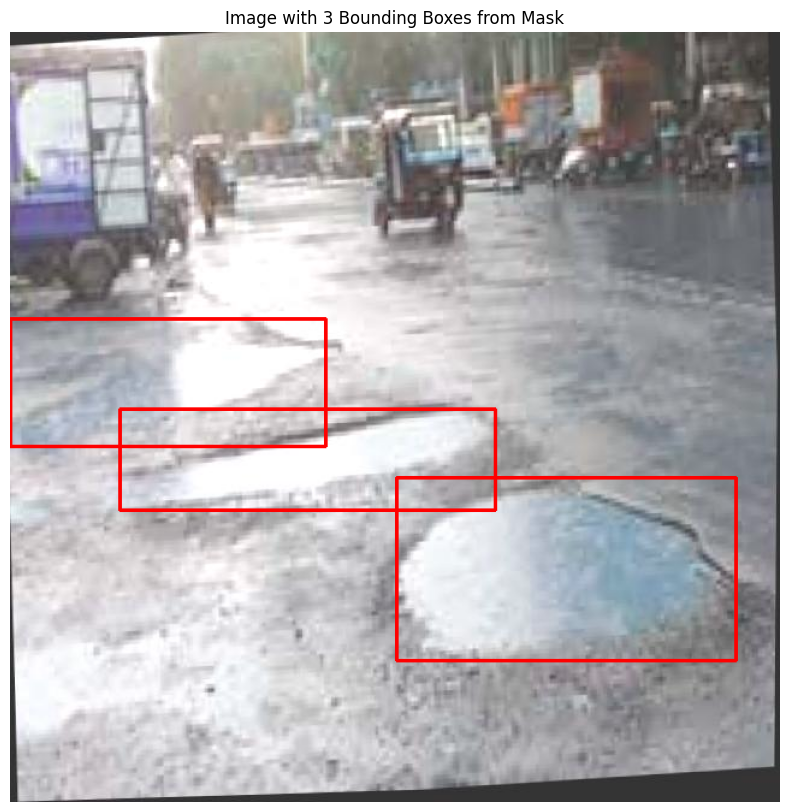

In [10]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for box in boxes:
    x_min, y_min, x_max, y_max = box
    cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)

plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
plt.title(f"Image with {len(boxes)} Bounding Boxes from Mask")
plt.axis('off')
plt.show()

In [39]:
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda"

sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_model.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [40]:
masks_path = os.path.join(base_dir, 'ground_truth_masks.pkl')
bbox_path = os.path.join(base_dir, 'bbox_coords.pkl')

with open(masks_path, "rb") as f:
    ground_truth_masks = pickle.load(f)

with open(bbox_path, "rb") as f:
    bbox_coords = pickle.load(f)

In [41]:
# Preprocess the images
transformed_data = defaultdict(dict)
keys = list(bbox_coords.keys())[0:100]
for k in keys:
  img_path = os.path.join(image_dir, f"{k}.jpg")
  image = read_image(img_path)
  transform = ResizeLongestSide(sam_model.image_encoder.img_size)
  input_image = transform.apply_image(image)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = sam_model.preprocess(transformed_image)
  original_image_size = image.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])

  transformed_data[k]['image'] = input_image
  transformed_data[k]['input_size'] = input_size
  transformed_data[k]['original_image_size'] = original_image_size

In [42]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.contiguous()
        target = target.contiguous()

        intersection = (pred * target).sum(dim=(2,3))
        union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

# Freeze encoder weights but allow gradient flow
for param in sam_model.image_encoder.parameters():
    param.requires_grad = False

for param in sam_model.prompt_encoder.parameters():
    param.requires_grad = False

sam_model.image_encoder.eval()
sam_model.prompt_encoder.eval()
sam_model.mask_decoder.train()

MaskDecoder(
  (transformer): TwoWayTransformer(
    (layers): ModuleList(
      (0-1): 2 x TwoWayAttentionBlock(
        (self_attn): Attention(
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (cross_attn_token_to_image): Attention(
          (q_proj): Linear(in_features=256, out_features=128, bias=True)
          (k_proj): Linear(in_features=256, out_features=128, bias=True)
          (v_proj): Linear(in_features=256, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=256, bias=True)
        )
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_fea

In [43]:
import random

num_epochs = 30
losses = []

for epoch in range(num_epochs):
    epoch_losses = []
    random.shuffle(keys)

    for k in keys:
        input_image = transformed_data[k]['image'].to(device)
        input_size = transformed_data[k]['input_size']
        original_image_size = transformed_data[k]['original_image_size']

        with torch.no_grad():
            image_embedding = sam_model.image_encoder(input_image)

        prompt_boxes = bbox_coords[k]
        gt_masks_for_image = ground_truth_masks[k]  # list of GT masks

        total_loss = 0.0

        for j, prompt_box in enumerate(prompt_boxes):
            gt_mask = gt_masks_for_image[j]

            box = transform.apply_boxes(prompt_box, original_image_size)
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)[None, :]

            with torch.no_grad():
                sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                    points=None,
                    boxes=box_torch,
                    masks=None,
                )

            low_res_mask, _ = sam_model.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=sam_model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )

            upscaled_mask = sam_model.postprocess_masks(low_res_mask, input_size, original_image_size).to(device)

            gt_mask_torch = torch.from_numpy(gt_mask).unsqueeze(0).unsqueeze(0).to(device)
            gt_mask_resized = torch.nn.functional.interpolate(
                gt_mask_torch.float(),
                size=upscaled_mask.shape[-2:],
                mode='bilinear',
                align_corners=False
            )
            gt_binary_mask = (gt_mask_resized > 0).float()

            b_loss = bce_loss(upscaled_mask, gt_binary_mask)
            d_loss = dice_loss(upscaled_mask, gt_binary_mask)
            total_loss += (0.5 * b_loss + 0.5 * d_loss)

        total_loss /= len(prompt_boxes)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_losses.append(total_loss.item())

    losses.append(epoch_losses)
    print(f'EPOCH: {epoch+1} loss: {sum(epoch_losses)/len(epoch_losses):.6f}')


EPOCH: 1 loss: 0.135341
EPOCH: 2 loss: 0.088001
EPOCH: 3 loss: 0.080132
EPOCH: 4 loss: 0.070624
EPOCH: 5 loss: 0.064963
EPOCH: 6 loss: 0.072881
EPOCH: 7 loss: 0.070260
EPOCH: 8 loss: 0.062653
EPOCH: 9 loss: 0.050993
EPOCH: 10 loss: 0.046270
EPOCH: 11 loss: 0.043887
EPOCH: 12 loss: 0.044217
EPOCH: 13 loss: 0.043142
EPOCH: 14 loss: 0.040023
EPOCH: 15 loss: 0.039303
EPOCH: 16 loss: 0.039163
EPOCH: 17 loss: 0.040593
EPOCH: 18 loss: 0.039361
EPOCH: 19 loss: 0.037161
EPOCH: 20 loss: 0.040602
EPOCH: 21 loss: 0.039964
EPOCH: 22 loss: 0.037727
EPOCH: 23 loss: 0.036809
EPOCH: 24 loss: 0.036943
EPOCH: 25 loss: 0.037693
EPOCH: 26 loss: 0.037158
EPOCH: 27 loss: 0.037247
EPOCH: 28 loss: 0.043941
EPOCH: 29 loss: 0.041133
EPOCH: 30 loss: 0.039909


In [44]:
!mkdir -p /content/drive/MyDrive/model_weights
decoder_path = "/content/drive/MyDrive/model_weights/mask_decoder.pth"
torch.save(sam_model.mask_decoder.state_dict(), decoder_path)

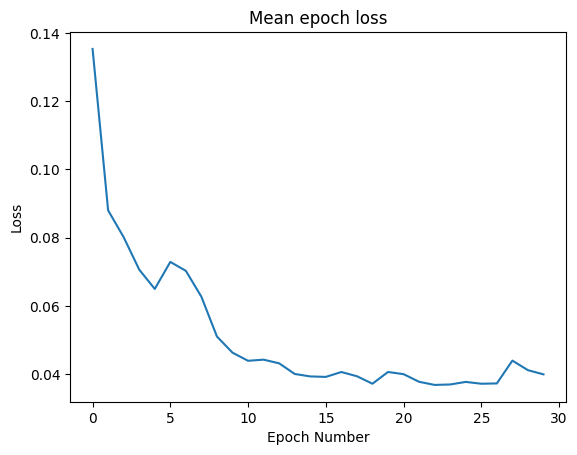

In [45]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

In [46]:
sam_model_orig = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_model_orig.to(device);

In [47]:
# Set up predictors for both tuned and original models
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [48]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [49]:
k = keys[21]
img_path = os.path.join(image_dir, f"{k}.jpg")
image = read_image(img_path)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = bbox_coords[k][0] #only first bounding box

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)
masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

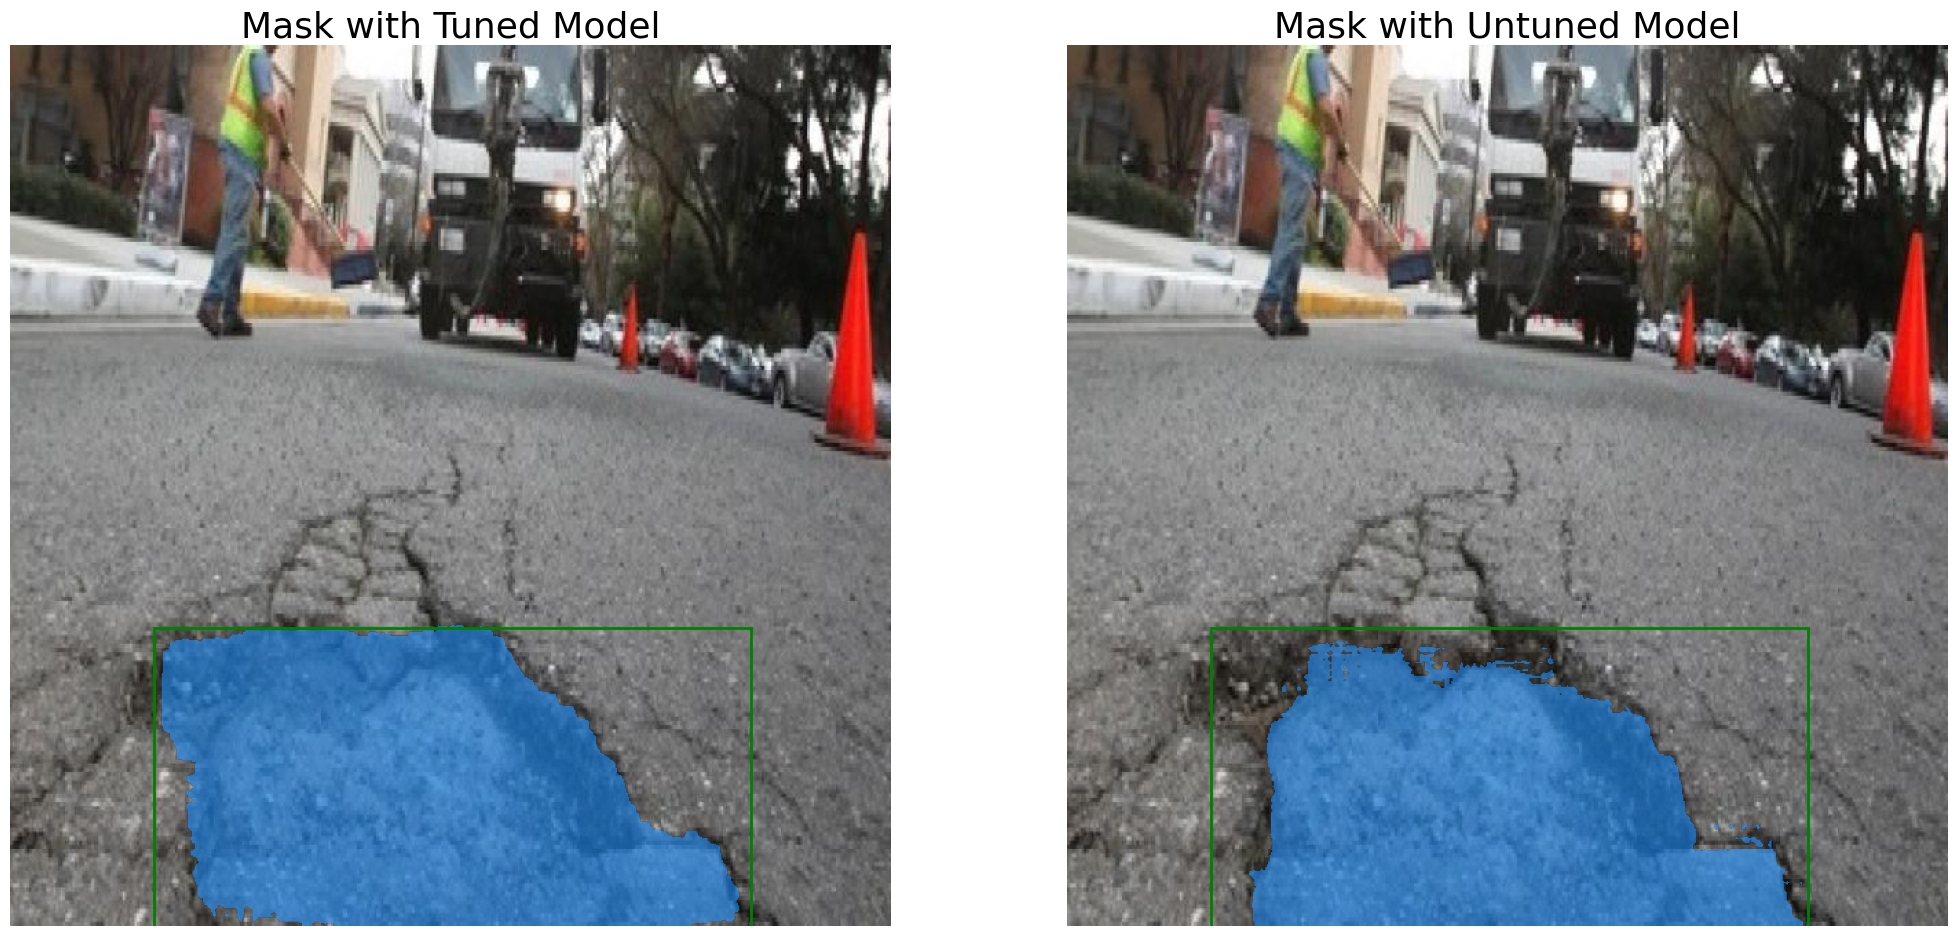

In [50]:
%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()

In [54]:
k = keys[88]
img_path = os.path.join(image_dir, f"{k}.jpg")
image = read_image(img_path)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = bbox_coords[k][0] #only first bounding box

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)
masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

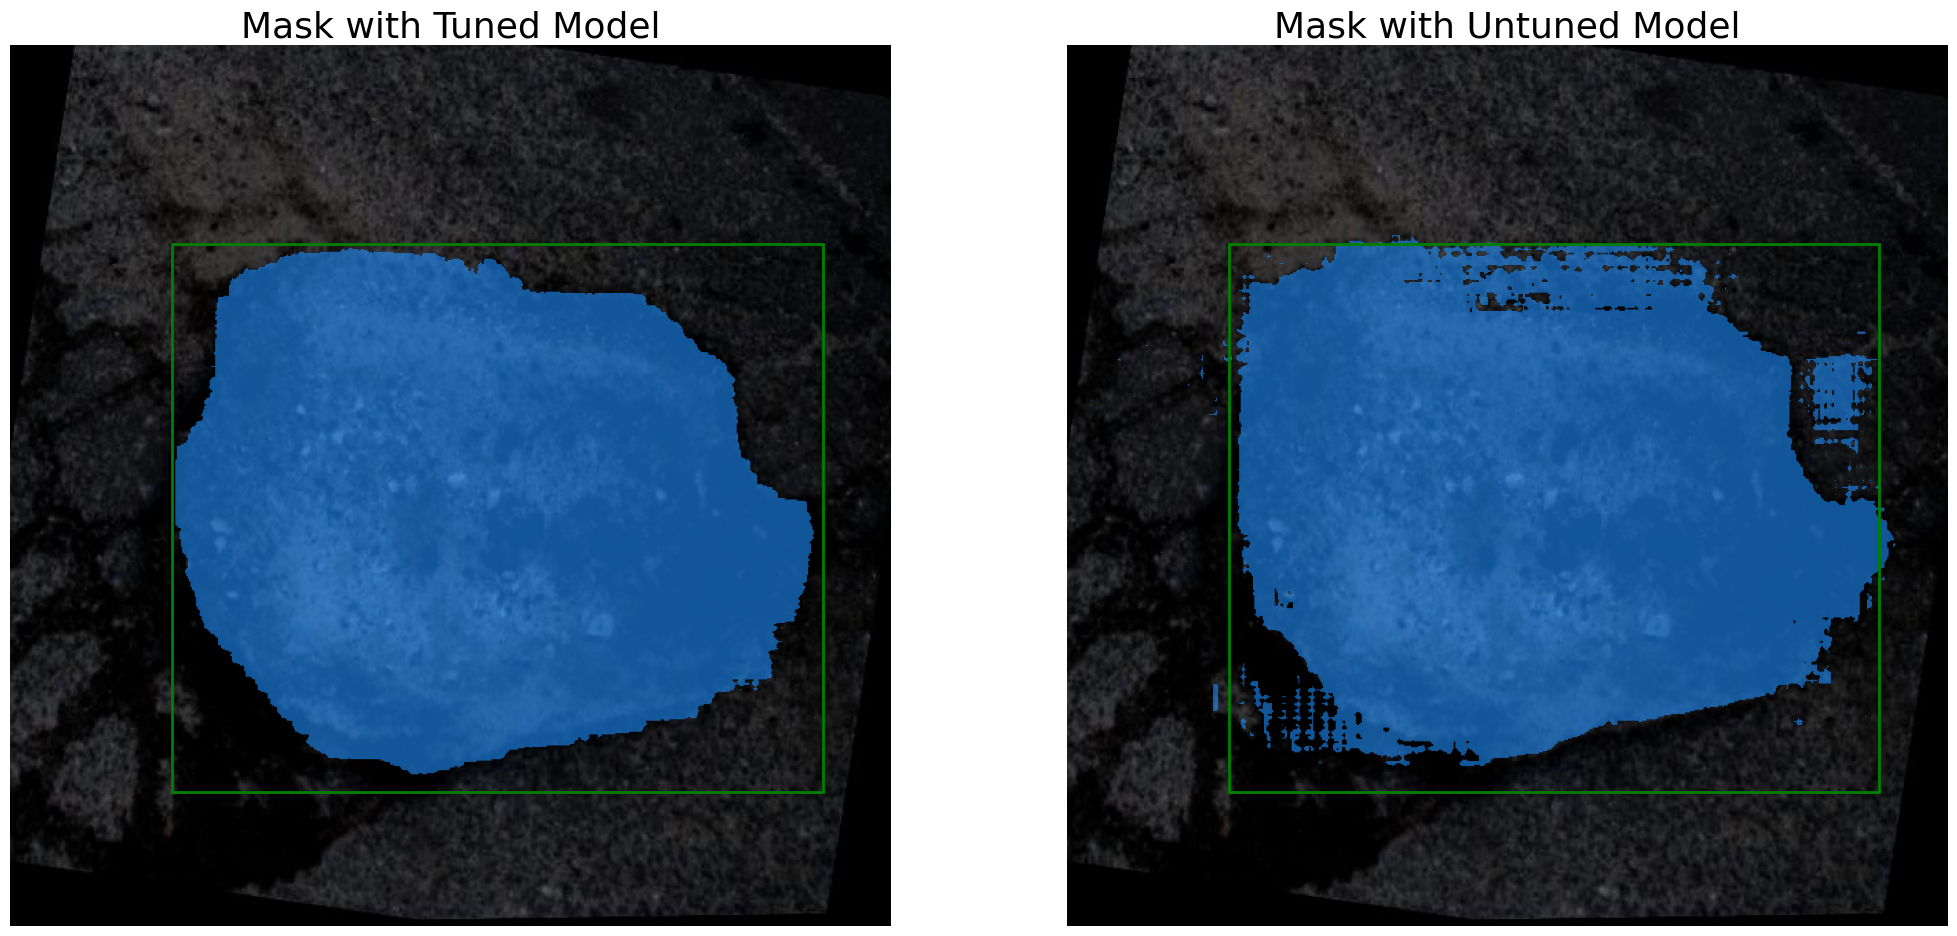

In [55]:
%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()

In [62]:
#let's check on one untrained images
keys = list(bbox_coords.keys())
k = keys[640]
img_path = os.path.join(image_dir, f"{k}.jpg")
image = read_image(img_path)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = bbox_coords[k][0] #only first bounding box

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)
masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

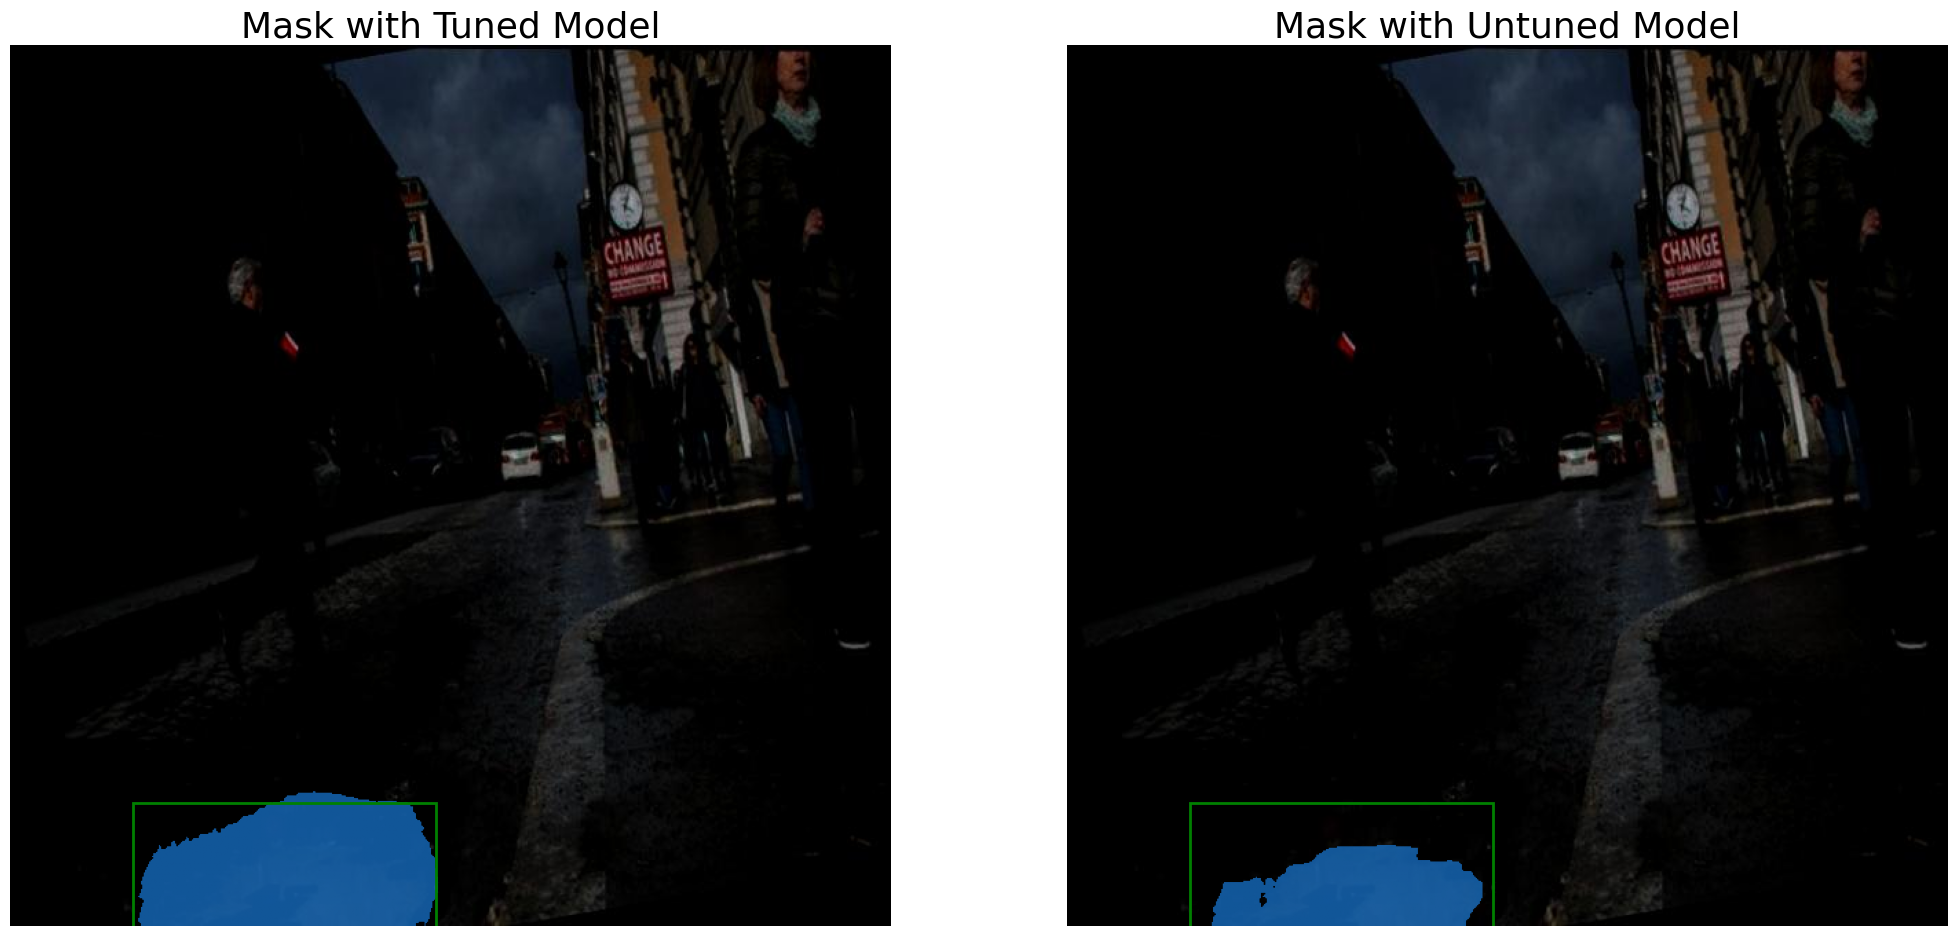

In [63]:
%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()

In [69]:
keys = list(bbox_coords.keys())
k = keys[710]
img_path = os.path.join(image_dir, f"{k}.jpg")
image = read_image(img_path)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = bbox_coords[k][0] #only first bounding box

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)
masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

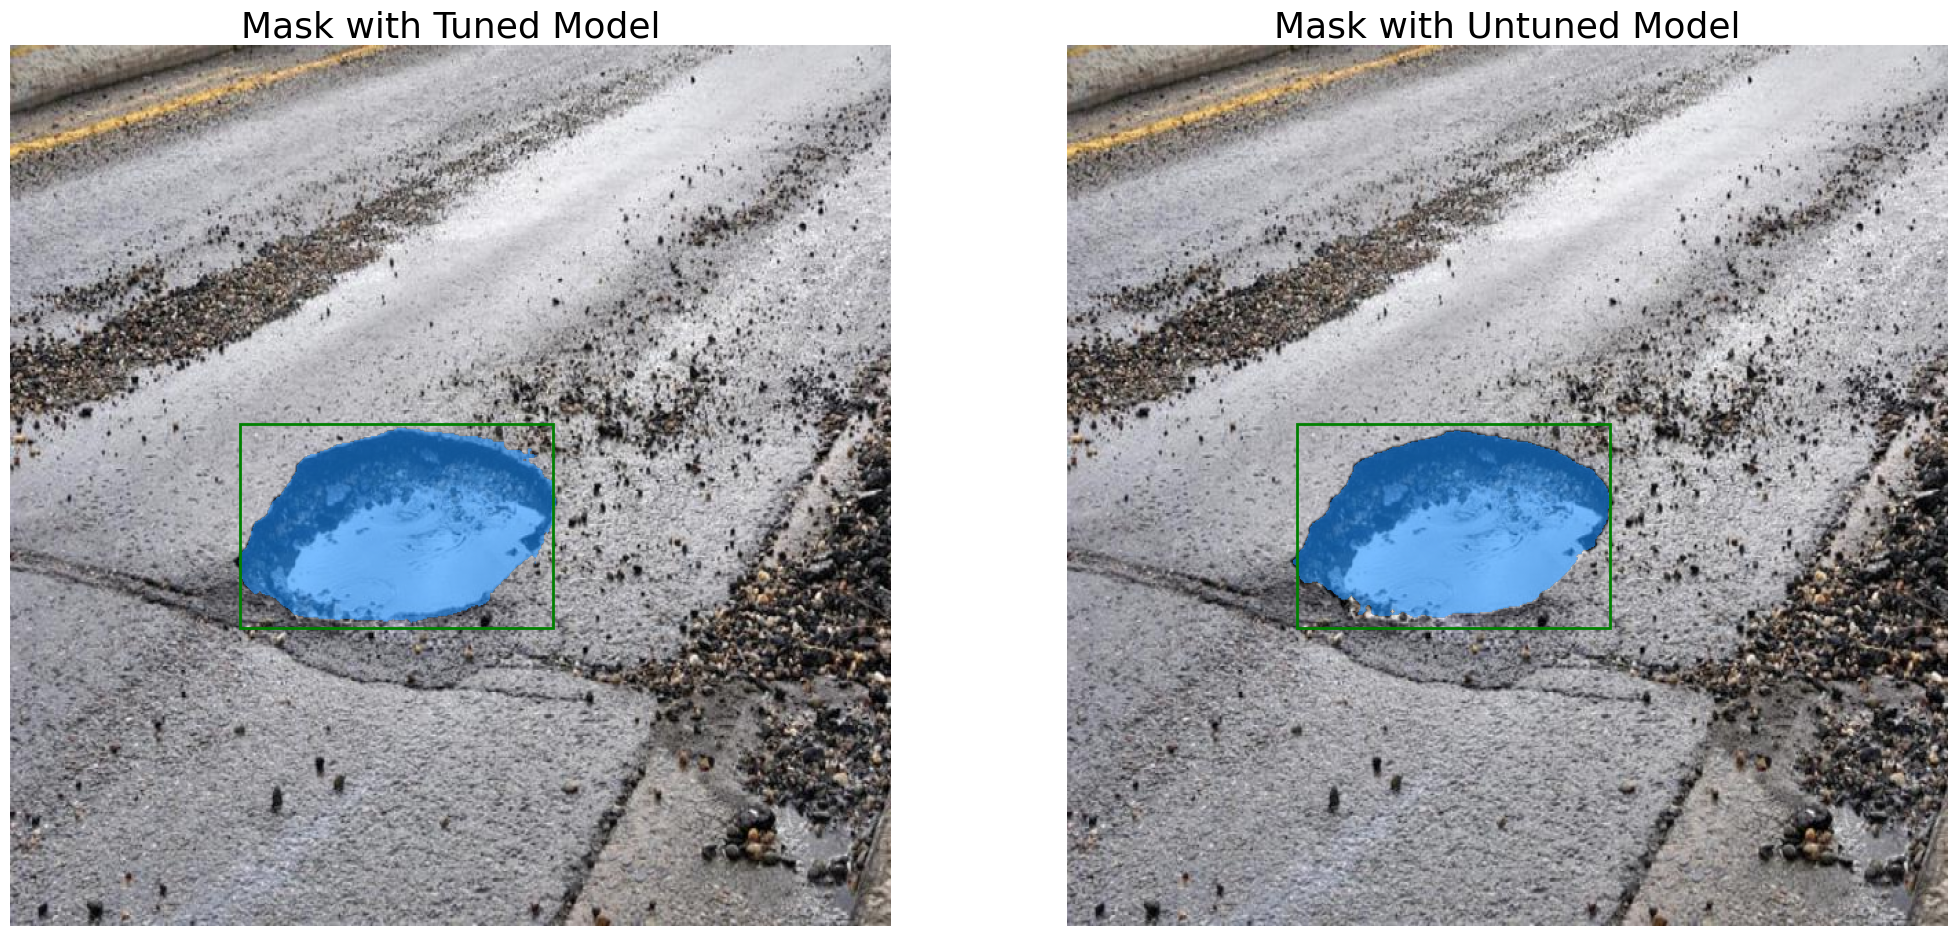

In [70]:
%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()

##Conclusion
The fine-tuned Segment Anything Model demonstrates significantly cleaner and more accurate masks compared to the original, untuned model. While the current results were achieved by training on only 100 images for 30 epochs, the model already shows strong potential in segmenting potholes effectively.

For even better performance, the model can be trained on the entire dataset and for a larger number of epochs. This would likely enhance its generalization and segmentation quality further. Nonetheless, even with this limited setup, the fine-tuning process has produced promising results, validating the approach.